In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import get_value, set_value
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn

In [2]:
device = torch.device('cpu:0')

In [2]:
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [3]:
sns.axes_style()
sns.set_style("white")
sns.set_context("notebook", rc={'axes.labelsize': 12.0, 'axes.titlesize': 14.0, 'legend.fontsize': 12.0, 'xtick.labelsize': 12.0, 'ytick.labelsize': 12.0})
sns.set_palette("deep")
plt.rcParams['image.cmap'] = 'viridis'

In [4]:
# Load results of the fitting procedure

subject = 1
fitting_type1 = 'texture_ridge_8ori_4sf_no_autocorrelations'
fitting_type2 = 'texture_ridge_8ori_4sf'
# fitting_type2 = 'simple_complex_ridge_8ori_4sf'
# fitting_type1 = 'gabor_ridge_8ori_3sf'
# fitting_type2 = 'gabor_combinations_ridge_8ori_3sf'
# fitting_type1 = 'gabor_ridge_36ori_12sf'
# fitting_type2 = 'gabor_PCA_36ori_12sf'

root = os.path.dirname(os.path.dirname(os.getcwd()))

# load first type of fitting
folder2load = os.path.join(root, 'model_fits','S%02d'%subject, fitting_type1)
# within this folder, assuming we want the most recent version that was saved
files_in_dir = os.listdir(folder2load)
from datetime import datetime
my_dates = [f for f in files_in_dir if 'ipynb' not in f and 'DEBUG' not in f]
my_dates.sort(key=lambda date: datetime.strptime(date, "%b-%d-%Y_%H%M"))
most_recent_date = my_dates[-1]

subfolder2load = os.path.join(folder2load, most_recent_date)
file2load = os.listdir(subfolder2load)[0]
fullfile2load = os.path.join(subfolder2load, file2load)

print('\nloading from %s\n'%fullfile2load)

out1 = torch.load(fullfile2load)
print(out1.keys())

# load second type of fitting (to compare)
folder2load = os.path.join(root, 'model_fits','S%02d'%subject, fitting_type2)
# within this folder, assuming we want the most recent version that was saved
files_in_dir = os.listdir(folder2load)
from datetime import datetime
my_dates = [f for f in files_in_dir if 'ipynb' not in f and 'DEBUG' not in f]
my_dates.sort(key=lambda date: datetime.strptime(date, "%b-%d-%Y_%H%M"))
most_recent_date = my_dates[-1]

subfolder2load = os.path.join(folder2load, most_recent_date)
file2load = os.listdir(subfolder2load)[0]
fullfile2load = os.path.join(subfolder2load, file2load)

print('\nloading from %s\n'%fullfile2load)

out2 = torch.load(fullfile2load)
print(out2.keys())


loading from /user_data/mmhender/imStat/model_fits/S01/texture_ridge_8ori_4sf_no_autocorrelations/Jul-01-2021_0002/all_fit_params

dict_keys(['feature_table_simple', 'sf_tuning_masks_simple', 'ori_tuning_masks_simple', 'cyc_per_stim_simple', 'orients_deg_simple', 'orient_filters_simple', 'feature_table_complex', 'sf_tuning_masks_complex', 'ori_tuning_masks_complex', 'cyc_per_stim_complex', 'orients_deg_complex', 'orient_filters_complex', 'aperture', 'aperture_rf_range', 'models', 'include_autocorrs', 'feature_info', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'best_params', 'lambdas', 'best_lambdas', 'best_losses', 'val_cc', 'val_r2', 'features_each_model_val', 'voxel_feature_correlations_val', 'zscore_features', 'nonlin_fn', 'padding_mode', 'n_prf_sd_out', 'autocorr_output_pix', 'debug'])

loading from /user_data/mmhender/imStat/model_fits/S01/texture_ridge_8ori_4sf/Jul-01-2021_0002/all_fit_params

dict_keys(['feature_table_simple', 'sf_

In [5]:
# Pulling out useful elements from the saved data

voxel_mask = out1['voxel_mask']
brain_nii_shape = out1['brain_nii_shape']
voxel_idx = out1['voxel_index']
voxel_roi = out1['voxel_roi']

assert(np.all(voxel_mask==out2['voxel_mask']))
assert(np.all(brain_nii_shape==out2['brain_nii_shape']))
assert(np.all(voxel_idx==out2['voxel_index']))
assert(np.all(voxel_roi==out2['voxel_roi']))


val_cc1 = out1['val_cc']
best_params1 = out1['best_params']
best_losses1 = out1['best_losses']
if 'best_lambdas' in out1.keys():
    best_lambdas1 = out1['best_lambdas']
else:
    best_lambdas1 = None
if 'lambdas' in out1.keys():
    lambdas1 = out1['lambdas']
else:
    lambdas1 = None

val_cc2 = out2['val_cc']
best_params2 = out2['best_params']
best_losses2 = out2['best_losses']
if 'best_lambdas' in out2.keys():
    best_lambdas2 = out2['best_lambdas']
else:
    best_lambdas2 = None
if 'lambdas' in out2.keys():
    lambdas2 = out2['lambdas']
else:
    lambdas2 = None

# also listing roi names here
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]
n_rois = len(group_names)


Text(0.5, 1.0, 'S01, texture_ridge_8ori_4sf')

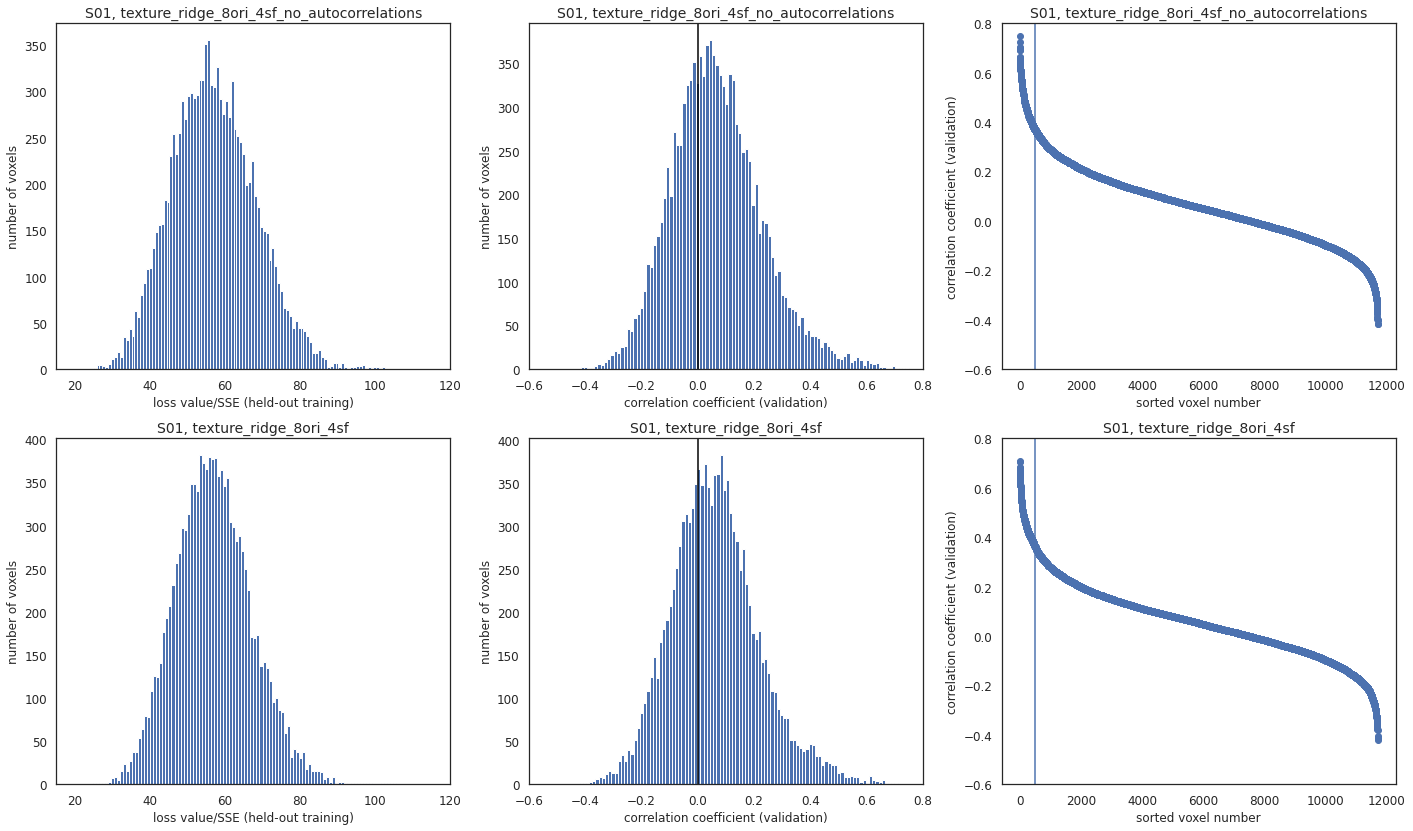

In [6]:
# Plot summary of performance
loss_lims = [15,120]
# loss_lims = [500,2000]
plt.figure(figsize=(24,14));

plt.subplot(2,3,1)
plt.hist(best_losses1,100)
plt.xlim(loss_lims)
plt.xlabel('loss value/SSE (held-out training)');
plt.ylabel('number of voxels');
plt.title('S%02d, %s'%(subject, fitting_type1))

plt.subplot(2,3,2)
plt.hist(val_cc1,100)
plt.xlim([-0.6, 0.8])
plt.xlabel('correlation coefficient (validation)');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')
plt.title('S%02d, %s'%(subject, fitting_type1))

plt.subplot(2,3,3)
plt.plot(np.sort(val_cc1)[::-1],'-o')
plt.axvline(500)
plt.ylim([-0.6, 0.8])
plt.xlabel('sorted voxel number')
plt.ylabel('correlation coefficient (validation)')
plt.title('S%02d, %s'%(subject, fitting_type1))

plt.subplot(2,3,4)
plt.hist(best_losses2,100)
plt.xlim(loss_lims)
plt.xlabel('loss value/SSE (held-out training)');
plt.ylabel('number of voxels');
plt.title('S%02d, %s'%(subject, fitting_type2))

plt.subplot(2,3,5)
plt.hist(val_cc2,100)
plt.xlim([-0.6, 0.8])
plt.xlabel('correlation coefficient (validation)');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')
plt.title('S%02d, %s'%(subject, fitting_type2))

plt.subplot(2,3,6)
plt.plot(np.sort(val_cc2)[::-1],'-o')
plt.axvline(500)
plt.ylim([-0.6, 0.8])
plt.xlabel('sorted voxel number')
plt.ylabel('correlation coefficient (validation)')
plt.title('S%02d, %s'%(subject, fitting_type2))

Text(0.5, 1.0, 'S01, simple_complex_ridge_8ori_4sf')

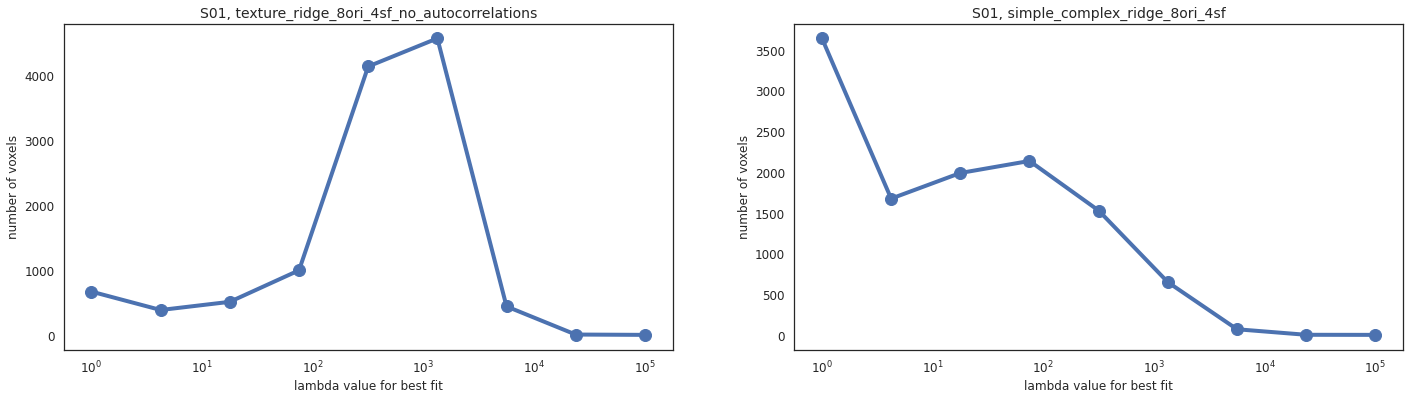

In [11]:
plt.figure(figsize=(24,6))

plt.subplot(1,2,1)
plt.plot(lambdas1, [np.sum(best_lambdas1==k) for k in range(len(lambdas1))], lw=4, marker='o', ms=12)
plt.xscale('log');
plt.xlabel('lambda value for best fit');
plt.ylabel('number of voxels');
plt.title('S%02d, %s'%(subject, fitting_type1))

plt.subplot(1,2,2)
plt.plot(lambdas2, [np.sum(best_lambdas2==k) for k in range(len(lambdas2))], lw=4, marker='o', ms=12)
plt.xscale('log');
plt.xlabel('lambda value for best fit');
plt.ylabel('number of voxels');
plt.title('S%02d, %s'%(subject, fitting_type2))

Text(0.5, 0.98, 'Correlation coef. on validation set\nS01\ntexture_ridge_8ori_4sf_no_autocorrelations (x axis) vs texture_ridge_8ori_4sf (y axis)')

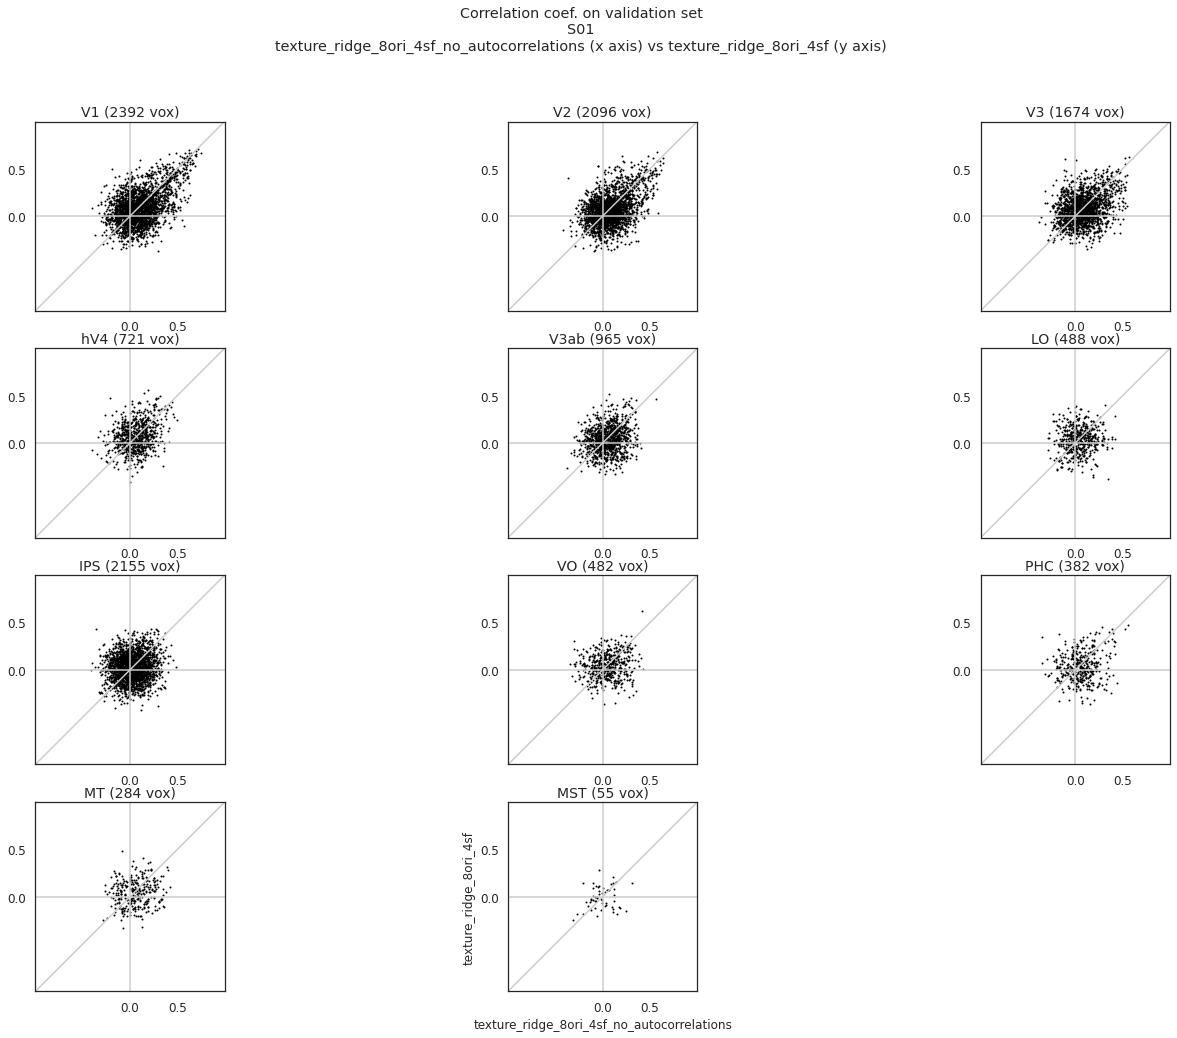

In [8]:
# Plot correlation coefficient for each ROI separately.

cclims = [-1, 1]
plt.figure(figsize=(24,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    plt.subplot(npx,npy,rr+1)

    vals1 = val_cc1[inds_this_roi]
    vals2 = val_cc2[inds_this_roi]

    plt.plot(vals1, vals2,'.',color='k',markersize=2)
    plt.axis('square')
    plt.xlim(cclims)
    plt.ylim(cclims)
    plt.xticks([0,0.5])
    plt.yticks([0,0.5])
    plt.axhline(0,color=[0.8, 0.8, 0.8])
    plt.axvline(0,color=[0.8, 0.8, 0.8])
    plt.plot(cclims, cclims,color=[0.8, 0.8, 0.8])
    if rr==n_rois-2:
        plt.xlabel(fitting_type1)
        plt.ylabel(fitting_type2)
    
    plt.title('%s (%d vox)'%(group_names[rr], np.sum(inds_this_roi)))

plt.suptitle('Correlation coef. on validation set\nS%02d\n%s (x axis) vs %s (y axis)'%(subject, fitting_type1, fitting_type2))